In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

for dirname, _, filenames in os.walk("/kaggle/input"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv


In [2]:
import zipfile

test1 = zipfile.ZipFile("/kaggle/input/dogs-vs-cats/test1.zip", "r")
test1.extractall()
test1.close()

train = zipfile.ZipFile("/kaggle/input/dogs-vs-cats/train.zip", "r")
train.extractall()
train.close()

In [3]:
import os
import shutil

from sklearn.model_selection import train_test_split

TRAIN_DIR = "/kaggle/working/train"

all_imgs = []
for i in os.listdir(TRAIN_DIR):
    img = os.path.join(TRAIN_DIR, i)
    if os.path.isfile(os.path.join(TRAIN_DIR, i)):
        all_imgs.append(img)


training, testing = train_test_split(all_imgs, test_size=0.2, random_state=42)

TRAINING_DIR = os.path.join(TRAIN_DIR, "Training")
TRAIN_CATS_DIR = os.path.join(TRAINING_DIR, "cats")
TRAIN_DOGS_DIR = os.path.join(TRAINING_DIR, "dogs")

TESTING_DIR = os.path.join(TRAIN_DIR, "Testing")
TEST_CATS_DIR = os.path.join(TESTING_DIR, "cats")
TEST_DOGS_DIR = os.path.join(TESTING_DIR, "dogs")


def create_dir(dir_name):
    if os.path.exists(dir_name):
        print(f"{dir_name} already exists")
    else:
        os.makedirs(dir_name)


def move_files(files, cat_dir, dog_dir):
    for file in files:
        if "cat." in os.path.basename(file):
            shutil.move(file, os.path.join(cat_dir, os.path.basename(file)))
        else:
            shutil.move(file, os.path.join(dog_dir, os.path.basename(file)))


create_dir(TRAIN_CATS_DIR)
create_dir(TRAIN_DOGS_DIR)

create_dir(TEST_CATS_DIR)
create_dir(TEST_DOGS_DIR)

move_files(training, TRAIN_CATS_DIR, TRAIN_DOGS_DIR)
move_files(testing, TEST_CATS_DIR, TEST_DOGS_DIR)

In [6]:
import tensorflow as tf

train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAINING_DIR, image_size=(150, 150), batch_size=32, label_mode="binary"
)

train_ds = train_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)

Found 20000 files belonging to 2 classes.


In [7]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    TESTING_DIR, image_size=(150, 150), batch_size=32, label_mode="binary"
)

test_ds = test_ds.cache().prefetch(tf.data.AUTOTUNE)

Found 5000 files belonging to 2 classes.


In [8]:
data_augmentation = tf.keras.models.Sequential(
    [
        tf.keras.Input(shape=(150, 150, 3)),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomTranslation(0.2, 0.2),
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomZoom(0.2),
    ]
)

In [24]:
import matplotlib.pyplot as plt


def visualize_augmentation(sample_img, aug_model, nums=4):
    preview_imgs = []

    sample_img_pil = tf.keras.utils.array_to_img(sample_img)
    preview_imgs.append(sample_img_pil)

    for i in range(nums):
        aug_img = aug_model(tf.expand_dims(sample_img, axis=0))
        aug_img_pil = tf.keras.utils.array_to_img(tf.squeeze(aug_img, axis=0))
        preview_imgs.append(aug_img_pil)

    fig, axes = plt.subplots(1, nums + 1, figsize=(12, 12))

    for index, ax in enumerate(axes):
        ax.imshow(preview_imgs[index])

        if index == 0:
            ax.set_title("Original")
        else:
            ax.set_title(f"Augmented {index}")

    plt.tight_layout()
    plt.show()

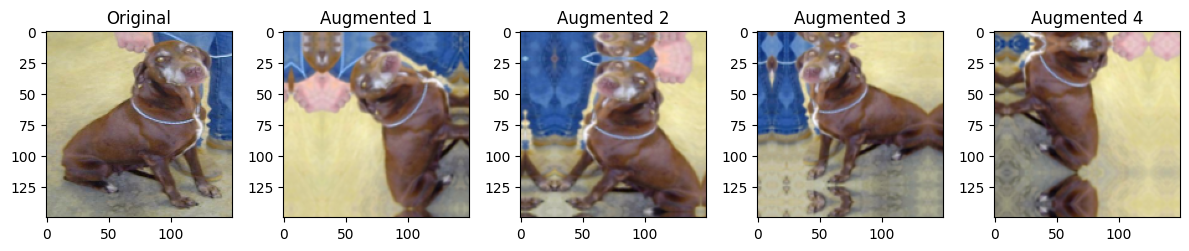

In [25]:
sample_batch = list(train_ds.take(1))[0][0]
visualize_augmentation(sample_batch[0], data_augmentation, nums=4)

In [9]:
def main_model():
    model = tf.keras.models.Sequential(
        [
            tf.keras.Input(shape=(150, 150, 3)),
            tf.keras.layers.Rescaling(1.0 / 255),
            tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
            tf.keras.layers.MaxPooling2D(2, 2),
            tf.keras.layers.Conv2D(32, (3, 2), activation="relu"),
            tf.keras.layers.MaxPooling2D(2, 2),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Conv2D(32, (3, 3), activation="relu"),
            tf.keras.layers.MaxPooling2D(2, 2),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(512, activation="relu"),
            tf.keras.layers.Dense(1, activation="sigmoid"),
            tf.keras.layers.Dropout(0.2),
        ]
    )

    return model

In [10]:
model = main_model()
full_model = tf.keras.models.Sequential([data_augmentation, model])

In [11]:
full_model.compile(
    tf.keras.optimizers.RMSprop(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

In [12]:
save_dir = "/Training_1/model.weights.h5"
dir_name = os.path.dirname(save_dir)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    save_dir, save_weights_only=True, verbose=1
)

In [13]:
history = full_model.fit(
    train_ds, validation_data=test_ds, epochs=25, callbacks=[cp_callback]
)

Epoch 1/25


2024-09-01 14:36:17.543952: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_2_1/sequential_1_2/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5166 - loss: 2.1062
Epoch 1: saving model to /Training_1/model.weights.h5
625/625 ━━━━━━━━━━━━━━━━━━━━ 47s 47ms/step - accuracy: 0.5166 - loss: 2.1062 - val_accuracy: 0.6184 - val_loss: 0.6640
Epoch 2/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5727 - loss: 2.1857
Epoch 2: saving model to /Training_1/model.weights.h5
625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 46ms/step - accuracy: 0.5728 - loss: 2.1857 - val_accuracy: 0.6408 - val_loss: 0.6263
Epoch 3/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6166 - loss: 2.0908
Epoch 3: saving model to /Training_1/model.weights.h5
625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 47ms/step - accuracy: 0.6166 - loss: 2.0909 - val_accuracy: 0.6506 - val_loss: 0.6246
Epoch 4/25
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6267 - loss: 2.1104
Epoch 4: saving model to /Training_1/model.weights.h5
625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 46ms/step - accuracy: 0.6267 - loss: 2.1104 - val_accurac

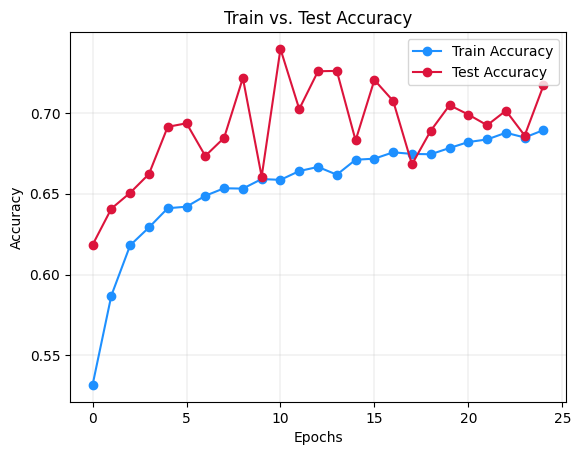

In [14]:
import matplotlib.pyplot as plt

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epoch = range(len(acc))

plt.plot(epoch, acc, color="dodgerblue", marker="o", label="Train Accuracy")
plt.plot(epoch, val_acc, color="crimson", marker="o", label="Test Accuracy")
plt.title("Train vs. Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(linewidth=0.2)
plt.legend()
plt.show()

In [16]:
from ipywidgets import widgets
from io import BytesIO
import numpy as np

uploader = widgets.FileUpload(accept="image/*", multiple=True)
display(uploader)
out = widgets.Output()
display(out)


def file_predict(file, filename, out):
    img = tf.keras.utils.load_img(file, target_size=(150, 150))
    img = tf.keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)

    prediction = full_model.predict(img, verbose=0)[0][0]

    with out:
        if prediction < 0.5:
            print(filename + " is cat")
        else:
            print(filename + " is dog")


def on_upload_change(change):
    uploaded_file = change["new"]

    for filename, file_info in uploaded_file.items():
        img = BytesIO(file_info["content"])
        file_predict(img, filename, out)


uploader.observe(on_upload_change, names="value")

FileUpload(value={}, accept='image/*', description='Upload', multiple=True)

Output()

In [26]:
full_model.save("model.h5")

TypeError: cannot pickle 'module' object